# Project 5 / Exploring the Madelon Data Set

### Description

Source: http://clopinet.com/isabelle/Projects/NIPS2003

This project will be working with UCI's Madelon data set. The data is completely artificial, randomly labeled +1 or -1 with 500 features. Of these 500 features, 20 of them are "real" features and the remaining 480 are "probes" which add noise to the data. Of the 20 real features, there are 5 informative features and the remaining 15 are linear combinations of the 5 informative features to add additional noise. The order of the features and patterns are randomized.

### Problem Statement

Predicting a synthetic data set such as the UCI's Madelon data set can be difficult because the features are anonymous. The goal is the project is to use statistical models to perform both feature extraction and classification.

### Solution Statement

To predict the labels (1 or -1) of this data set, four models will be built. First, a naive logistic regression (no regularization penalty) will be made as the benchmark for our classification score. Second, a logistic regression model with a L1 normalization penalty to regularization for the data set's features. Third, a logistic regression model whose parameters are tuned through a Grid Search and Cross-Validation. Finally, a K-Nearest Neighbor Classifier with parameters tuned through Grid Search will be used in case the data set is non-linear.

### Metric

I will be measuring "accuracy", based on the percentage of the model label the data points correctly. I will look at a confusion matrix to identify the false positives and the Area Under Curve (AUC). In addition, KNN's accuracy can be calculated by the standard Minkowski metric. However, the results of the KNN will be comparable to the logistic regression through AUC and confusion matrix analysis.

### Benchmark

The benchmark will be a naive Logistic Regression (with no regularization penalty) for our classification score.

### Import Module

This module contains wrapper functions to load the data, make a data dictionary, model the data, and transform the data.

In [1]:
from lib.project_5 import load_data_from_database, make_data_dict, general_model, general_transformer, plot_confusion_matrix

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Import Packages

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

## Step 1: Benchmarking

### Implementation

The schematic below shows the methodology for building the benchmark logistic regression model. First load the data into a Pandas dataframe, then separate the features from the labels (target vector). Make the data dictionary, which stores train-test split of the provided data. 

<img src="assets/benchmarking.png" width="600px">

#### 1. `load_data_from_database()`

In [3]:
madelon_df = load_data_from_database()
madelon_df.head()

,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_491,feat_492,feat_493,feat_494,feat_495,feat_496,feat_497,feat_498,feat_499,label
index,,,,,,,,,,,,,,,,,,,,,
0,485,477,537,479,452,471,491,476,475,473,...,481,477,485,511,485,481,479,475,496,-1
1,483,458,460,487,587,475,526,479,485,469,...,478,487,338,513,486,483,492,510,517,-1
2,487,542,499,468,448,471,442,478,480,477,...,481,492,650,506,501,480,489,499,498,-1
3,480,491,510,485,495,472,417,474,502,476,...,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,...,479,452,435,486,508,481,504,495,511,1


#### 2. Features and Target Variables

In [4]:
# Target
y = madelon_df['label']

# Features
madelon_features = [col for col in madelon_df.columns if col != 'label']
X = madelon_df[madelon_features]

#### 3. Create Data Dictionary with `make_data_dict()`

In [5]:
data_dict = make_data_dict(X, y)

#### 4. Transform the Data with `general_transformer()`

In [6]:
transformed_data_dict = general_transformer(StandardScaler(), data_dict)

#### 5. Perform the Logistic Regression with `general_model()`

In [7]:
logit_output = general_model(LogisticRegression(), transformed_data_dict)

In [8]:
print logit_output['scores']

[('train score:', 0.79333333333333333), ('test score:', 0.498)]


In [9]:
print logit_output['model']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#### 6. Plot the Confusion Matrix

Normalized confusion matrix
[[ 0.48648649  0.51351351]
 [ 0.48962656  0.51037344]]


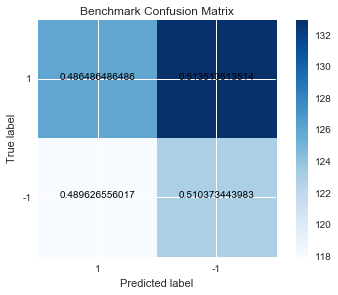

In [10]:
confusion = confusion_matrix(logit_output['y_test'],logit_output['prediction'])
plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True, title='Benchmark Confusion Matrix')

#### 7. Area Under the Curve (AUC)

In [11]:
fpr_lr, tpr_lr, _ = roc_curve(logit_output['y_test'],logit_output['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.49842996523494443

---

## Step 2: Identify Salient Features Using $\ell1$-penalty

### Implementation

The schematic below uses logistic regression by selecting important features (L1 norm). Instead of predicting on the test set, a table of coefficients is obtained, with larger coefficients being more meaningful than smaller coefficients.

<img src="assets/identify_features.png" width="600px">

#### 1. `load_data_from_database()`

In [12]:
madelon_df = load_data_from_database()

#### 2. Features and Target Variables

In [13]:
# Target
y = madelon_df['label']

# Features
madelon_features = [col for col in madelon_df.columns if col != 'label']
X = madelon_df[madelon_features]

#### 3. Create Data Dictionary with `make_data_dict()`

In [14]:
data_dict = make_data_dict(X, y)

#### 4. Transform the Data with `general_transformer()`

In [15]:
transformed_data_dict = general_transformer(StandardScaler(), data_dict)

### Logistic Regression using L1 Penalty

In [16]:
logit_l1_output = general_model(LogisticRegression(penalty='l1'), transformed_data_dict)

In [17]:
print logit_l1_output['scores']

[('train score:', 0.78866666666666663), ('test score:', 0.53000000000000003)]


In [18]:
print logit_l1_output['model']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#### 5. Identify Important Features with Model-Based Feature Selection

Model-based feature selection uses supervised machine learning to judge the importance of each feature and only keeps the most important ones. The feature selection model provides a measure of importance for each feature, so that they can be ranked by this measure.

In [19]:
#looking at coefficents from l1 norm regularization
l1_features = pd.DataFrame(logit_l1_output['processes'][1].coef_[0],X.columns,columns=['coef'])
l1_features.sort_values(['coef'],ascending = False).head(10)

,coef
feat_475,0.840775
feat_048,0.498097
feat_453,0.384361
feat_493,0.379168
feat_064,0.269335
feat_451,0.267794
feat_012,0.267678
feat_061,0.238361
feat_455,0.237175
feat_137,0.236545


#### 6. Plot the Confusion Matrix

Normalized confusion matrix
[[ 0.55186722  0.44813278]
 [ 0.49034749  0.50965251]]


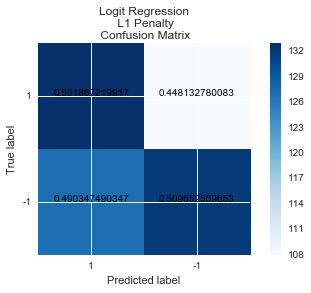

In [20]:
confusion = confusion_matrix(logit_l1_output['y_test'],logit_l1_output['prediction'])
plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True, title='Logit Regression\n L1 Penalty\n Confusion Matrix')

#### 7. Area Under the Curve (AUC)

In [21]:
fpr_lr, tpr_lr, _ = roc_curve(logit_l1_output['y_test'],logit_l1_output['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.53075986478476112

---

# Step 3: Build Model - Grid Search Logistic Regression/KNN

## Implementation

<img src="assets/build_model.png" width="600px">

#### 1. `load_data_from_database()`

In [22]:
madelon_df = load_data_from_database()
madelon_df.head()

,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_491,feat_492,feat_493,feat_494,feat_495,feat_496,feat_497,feat_498,feat_499,label
index,,,,,,,,,,,,,,,,,,,,,
0,485,477,537,479,452,471,491,476,475,473,...,481,477,485,511,485,481,479,475,496,-1
1,483,458,460,487,587,475,526,479,485,469,...,478,487,338,513,486,483,492,510,517,-1
2,487,542,499,468,448,471,442,478,480,477,...,481,492,650,506,501,480,489,499,498,-1
3,480,491,510,485,495,472,417,474,502,476,...,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,...,479,452,435,486,508,481,504,495,511,1


#### 2. Feature and Target Variables

In [23]:
# Target
y = madelon_df['label']

# Features
madelon_features = [col for col in madelon_df.columns if col != 'label']
X = madelon_df[madelon_features]

#### 3. Make Data Dictionary

In [24]:
data_dict = make_data_dict(X, y)

### Transform the Data 
#### 4. With `StandardScaler()`

In [25]:
scaled_dict = general_transformer(StandardScaler(), data_dict)

#### 5. With `SelectKBest()`

In [26]:
sel_kbest_std = general_transformer(SelectKBest(k=5), scaled_dict)

### Gridsearch Parameters for Logistic Regression

In [27]:
lr = LogisticRegression()

lr_params = {'penalty':['l1', 'l2'],
             'solver':['liblinear'],
             'C':np.linspace(0.001, 10, 100)}

In [28]:
gridsearch_logit = general_model(GridSearchCV(lr, lr_params, n_jobs=-1), sel_kbest_std)

#### 6. Best Parameters and Score

In [29]:
print "Best estimator:", gridsearch_logit['model'].best_estimator_
print ''
print "Best parameters:", gridsearch_logit['model'].best_params_
print ''
print "Train score:", gridsearch_logit['train_score']
print "Test score:", gridsearch_logit['test_score']

Best estimator: LogisticRegression(C=0.20300000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Best parameters: {'penalty': 'l1', 'C': 0.20300000000000001, 'solver': 'liblinear'}

Train score: 0.608666666667
Test score: 0.64


#### 7. Confusion Matrix

Normalized confusion matrix
[[ 0.63498099  0.36501901]
 [ 0.35443038  0.64556962]]


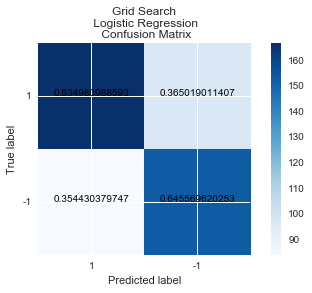

In [30]:
confusion = confusion_matrix(gridsearch_logit['y_test'],
                             gridsearch_logit['prediction'])

plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True, 
                          title='Grid Search\n Logistic Regression\n Confusion Matrix')

#### 8. Area Under the Curve (AUC)

In [31]:
fpr_lr, tpr_lr, _ = roc_curve(gridsearch_logit['y_test'],gridsearch_logit['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.64027530442316016

### Gridsearch Parameters for KNN

In [32]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors': range(1,101,2),
              'weights':['uniform', 'distance']}

In [33]:
gridsearch_knn = general_model(GridSearchCV(knn, knn_params, n_jobs=-1), sel_kbest_std)

#### 9. Best Parameters and Score

In [34]:
print "Best estimator:", gridsearch_knn['model'].best_estimator_
print ''
print "Best parameters:", gridsearch_knn['model'].best_params_
print ''
print "Train score:", gridsearch_knn['train_score']
print "Test score:", gridsearch_knn['test_score']

Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

Best parameters: {'n_neighbors': 15, 'weights': 'distance'}

Train score: 1.0
Test score: 0.71


#### 10. Confusion Matrix

Normalized confusion matrix
[[ 0.70722433  0.29277567]
 [ 0.28691983  0.71308017]]


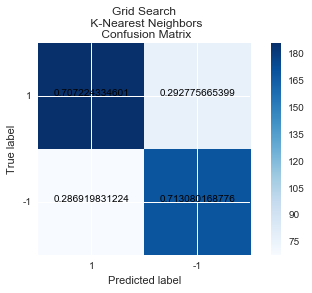

In [35]:
confusion = confusion_matrix(gridsearch_knn['y_test'],
                             gridsearch_knn['prediction'])

plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True, 
                          title='Grid Search\n K-Nearest Neighbors\n Confusion Matrix')

#### 11. Area Under the Curve (AUC)

In [36]:
fpr_lr, tpr_lr, _ = roc_curve(gridsearch_knn['y_test'],gridsearch_knn['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.71015225168856588